## Project Dataset Introduction: San Francisco 311 Cases 

Provided by [DataSF](https://data.sfgov.org/City-Infrastructure/311-Cases/vw6y-z8j6), this set is a monstrosity containing about 4.25 Million rows and counting. For those not familiar, 311 is a general customer service number for city government, most commonly associated with non-emergency complaints. 311 cases can be created via phone, mobile, and web. The dataset covers the time period from July 2008 until present. 

In order to do data exploration and analysis of this dataset we needed to make a working sample to reduce memory and cpu usage upfront: 
    <pre><code>awk 'BEGIN {srand()} !/^$/ { if (rand() <= .01 || FNR==1) print $0}' filename</code></pre>

Further information about the dataset can be found [here.](https://support.datasf.org/help/311-case-data-faq)


## One of the fascinating aspects of city living is human behavior.
One behavior every human seems to enjoy is complaining, in some shape way or form. Whether its done in exercise of rights to recourse, for entertainment, or out of civic duty, we encounter a situtation that make us uncomfortable... and we file a 311 case on it. I wanted to focus on the subset of cases that truly reflect the spirit of 'complaints,' in particular those concerned with the behavior of others, and generally require some sort of short term physical response. Sadly, it seems there aren't many cases filed to commend folks for good behavior, so we will be looking at mostly negative or unpleasant situatioons here. Accordingly, we have attempted to exclude cases concerning general administrative requests, such as building permits, tree maintenance,  and the like. In addition, despite it being filled with negative comments, I also chose to exclude the muni category, insofar as the Muni (city bus & train operators) is its own organization with its own culture, that I don't care to upset by pointout the exceedingly high volume of complaints.

From my personal observation, corrorated by many of my peers, once the 311 case is filed it goes into a black box, and we can only hope to guess at if or when the matter will be addressed. This can be very frustrating for the complainant which in turn probably results in corrsponding frustration for the people inside the black box, who receive many repeated complaints, doubtless with inversely proportional civility. 
### If only there were a way to *predict* how long it would take to resolve each issue... 
Well, luckily, there *are* ways, and we shall see what fruit they may bear. 

Datacleaning highlight: encode, convert or cast *every single feature*



In [256]:
!pwd


/home/dliu/lambda/unit-2/DS-Unit-2-Build-dmhliu


In [257]:
import pandas as pd
import numpy as np
import math 
import pprint
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

pp = pprint.PrettyPrinter(indent=4)
pd.options.display.max_columns = 100
pd.set_option('display.max_rows', 100)


In [258]:
# Get Pandas Profiling Report
import pandas_profiling
#pandas_profiling.ProfileReport(df)

In [259]:
df = pd.read_csv('reduced1.csv', header=0, error_bad_lines=False, engine="python", warn_bad_lines=False);

In [260]:
## experiment in oop
## instantiate  a wrangler and setup drops and encoding. 
## run methods on the internal working copy to iterate 
## 

class Wrangler:        
    """the intent is for each instance of wrangler to contain lists of 
    specific transformations to be performed on an dataframe
    by the class methods. """
    #class vars
    dropcols = list()    #list to store columns to drop
    droprows = dict()    #row boolean filters

    encoders = dict()    # colname, function to be applied to elements
    
    dropcols_post = list()  #keep a distinct list to drop after enconding

    def calc_lt_005_cat(self, df): 
        """ return a list of the bottom .5% category names for binning"""
        return df.Category.value_counts()[df.Category.value_counts(normalize=True).values < .005]

    def __init__(self, data):
        self.raw_df = data.copy()         #preserve the original dataframe
        self.working = self.raw_df.copy() #this will be passed around or be used as default by class methods
        
    #methods
    def set_data(self,newdf):
        """reset dataframe to new df, leaving configuration intact"""
        print('set data to df', df.shape)
        self.raw_df= newdf.copy()
        self.working = self.raw_df.copy()
        return self.working
    
    def add_to_dropcols(self,labels):
        for l in labels:
            if l in self.dropcols:
                print('error column already in dropcols list')
                break
                return self.dropcols
        self.dropcols.extend(labels)
        return self.dropcols

    def get_dropcols(self):         #why use accessor methods in python? 
        
        if not self.dropcols: 
            print('no columns to drop')
        return self.dropcols
    
    def clear_dropcols(self):
        self.dropcols=list()
        return True
    def get_nancols(self, df=None, store=False):
        if df is None: 
            df=self.working
        cols =df.columns
        nc=df[cols].isnull().sum().index.tolist()
        if store:
            self.nancols = nc
        return nc
    def add_to_droprows(self, name, expr):
        self.droprows[name] = expr 
        return self.droprows.keys()

   
    def add_encoding(self, label, mapper):
        try:
            label in self.working.columns
        except:
            print(label, 'not found in working copy, may have been dropped')
            assert label in self.raw_df.columns
        self.encoders[label]= mapper
    ###TODO: 
    def get_params(self):
        pass
        #return all wrangler settings 
    def set_nanval(self):   
        pass 
       # self.nanvals add self to 

#"internal"
    def drop_rows_by_mask(self,df=None,labels=None):
        """takes a dataframe, and list of labels to drop INPLACE,
        returns the modified dataframe"""
        if df is None:
            df=self.working
        if labels is None:
            print('dropping all in droprows..')
            if self.droprows:
                labels = list(self.droprows.keys())
        mask = self.droprows[labels[0]]  #get first boolean mask
        for l in labels: 
            print('\napplying mask: ',l )
            mask = mask | self.droprows[l]   #or them all together
        df.drop(index=df[mask].index,inplace=True)
        return df 
    
    def drop_dupes(self, df=None):
        """INPLACE: drop duplicate rows in df,
        return modified copy"""
        if df is None:
            df=self.working
        todropindex = df[df.duplicated()].index
        print('\n dropping',todropindex.shape, 'rows')
        df.drop(todropindex,axis=0, inplace=True)
        return df

    def drop_columns(self,df=None, list=None):
        """INPLACE if df provided, use working
        if no list is provided, drop all columns in list
        if list is provided, drop only the columns in argument list
        and add them to the dropcols list
        return modified dataframe"""
        
        if df is None:
            df = self.working  
        if list:                          #list of droplabels is passed, added to self.dropcols,then dropped.
            for l in list:
                if l in self.dropcols:
                    print('error column already in dropcols list')
                    break
                    return self.dropcols
            self.dropcols.extend(list)
        else:
            list= self.dropcols
                                   #TODO: check dropcols present in df.columns
        return df.drop(labels=list, axis=1, inplace=True)
    
    def drop_columns_post(self):
        """INPLACE drop any columsn in list dropcols_post 
        dont return anything"""
        drop_columns(list=dropcols_post)
        
    def bin_othercats(self):
        """to help reduce cardinality bin the lower .5pct of categories as other
            CAUTION need to do this after dropping bad data rows, it will change every time
            the df is resampled.... """
        df = self.working
        othercats = self.calc_lt_005_cat(df).index.tolist()
        df['Category'] = df.Category.map(lambda cat : 'other' if cat in othercats else cat)
        
    def encode(self,df=None, label=None, fun=None):
        """label is key for dict AND is column label 
        fun is a function for pd.Series.map() 
        """
        if df is None: 
            df=self.working
            print('\n Encoding, changing working copy..')
        if fun is None:
            fun = list(self.encoders.keys()) 
            for k in fun:
                print('  ... encoding column: ',k)
                df[k] = df[k].map(self.encoders[k])
        else:
            df[label] = df[label].map(fun)
        return df
    
    def to_datetime(self, cols=None, df=None):
        if df is None:
            df=self.working
            print('\nworking df is being changed..')
        if cols is None:
            cols=self.dt_cols
        for c in cols:
            print('converting',c,'to datetime')
            try:
                df[c] = pd.to_datetime(df[c],infer_datetime_format=True)  #inplace 
            except: 
                print('error - possible this column needs cleaning')
        return df

       
    def make_feature(self,newlabel,input,fun):      #make or overwrite column newlabel
        df=self.working
        try:
            df[newlabel] = df[input].apply(fun, axis=1)  #or map or tranform?
            print('\nadded feature:', newlabel)
        except:
            print('there was a problem, not added!!')
            return False
        return True
    def calc_open_cases(self, sometime):  #input time
        df= self.working[['CaseID','Opened','Closed']]
        opened_prior = df['Opened'] < sometime        # cases opened before it,
        not_closed_prior = ~(df['Closed'] < sometime) # not closed, 
        open_at_thattime = opened_prior & not_closed_prior  #and 
        return open_at_thattime.sum()
    
    order_default = [drop_rows_by_mask,
                    drop_columns, 
                    drop_dupes,
                    encode,
                    drop_columns_post]   #list of methods in order of application

    def wrangle(self, df=None):

        if df is None:
            df =self.raw_df.copy() # start from the beginning 
            result = df
            print('will apply :', self.order_default)
            for f in self.order_default:
                print('level')
                result = f(result)
        return result
    

In [261]:
##column lists after exploration and research

delete = [s for s in df.columns.values if 'DELETE - ' in s]   #columns have delete in name, the appear to be older version of data
boundary = [s for s in df.columns.values if 'Boundary' in s]   #columns have boundary in name, dont need, redundant with neighborhood
floatcols = df.select_dtypes(include='float64').columns


In [262]:
##define settings here 
wrangler = Wrangler(df)   
wrangler.clear_dropcols()

wrangler.add_to_dropcols(delete)
wrangler.add_to_dropcols(['Point'])  ##redundant w/ lat long, but may use for geospatial later
wrangler.add_to_dropcols(['Parks Alliance CPSI (27+TL sites)','Supervisor District'])
wrangler.add_to_dropcols(['Central Market/Tenderloin Boundary Polygon - Updated'])
wrangler.add_to_dropcols(['Civic Center Harm Reduction Project Boundary',
       'Fix It Zones as of 2017-11-06 ', 'Invest In Neighborhoods (IIN) Areas',
       'Fix It Zones as of 2018-02-07','SF Find Neighborhoods',
       'CBD, BID and GBD Boundaries as of 2017','Current Supervisor Districts',
       'Central Market/Tenderloin Boundary', 'Areas of Vulnerability, 2016',
       'HSOC Zones as of 2018-06-05', 'OWED Public Spaces'])

missing_to_0 = lambda x : 0 if math.isnan(x) else int(x)   #convert float to int, nan to zeros
missing_to_unk =  lambda x : x if type(x) == str else 'missing'  #for strings 

wrangler.add_encoding('Request Details', missing_to_unk)
wrangler.add_encoding('Neighborhood', missing_to_unk)
wrangler.add_encoding('Police District', missing_to_unk)

wrangler.add_encoding('Analysis Neighborhoods', missing_to_0)  #convert neigborhoods
wrangler.add_encoding('Neighborhoods', missing_to_0) 
wrangler.add_encoding('Street', missing_to_unk )
wrangler.add_encoding('Media URL', lambda x : 'present' if type(x) == str else 'missing')


In [263]:
### special alert, some of our nasty data yields 

def caseid_to_int (x):    #convert good caseids to int, bad to zero for drop
    try:
        i = int(x)
    except:
        i = 0   
        return 0      #strings are converted to zero for dropping 
    return i

wrangler.droprows['drop_missing_caseid'] = df.CaseID.map(caseid_to_int) == 0    #mask to drop rows with no caseid
wrangler.add_encoding('CaseID', caseid_to_int)        #can be done any order



In [264]:

## Rows to drop 

nopen = df.Opened.isnull()    # bad records null, open date

wrangler.droprows['drop null open date'] = nopen #migh be fixed by  missing caseID?

nclosed= df.Closed.isnull()   # some are really still open this doenst need to be dropped.



excluded_cats =['SFHA Requests',     #these are adminstrative, e.g temp signs, or belong to other departments and are not centered around human behavior
                'Sidewalk or Curb',
                'Temporary Sign Request',
                'Tree Maintenance',
                'Rec and Park Requests']
#more infrastructure generic requests 
gen_req =['General Request - PUBLIC WORKS',    # is street cleaning in here?

        'Sewer Issues', 'Streetlights',
        'Sign Repair', 
        'General Request - PUC',
        'General Request - COUNTY CLERK',
        'General Request - 311CUSTOMERSERVICECENTER',               
        'General Request - MTA']
#
exclude_gen = df.Category.isin(gen_req)
exclude_svc = df.Category.isin(excluded_cats)  
muni = df.Category== 'MUNI Feedback'   #bus complaints we dont want, DPW doesnt service 

wrangler.add_to_droprows('muni', muni);
wrangler.add_to_droprows('svc_req', exclude_svc)
wrangler.add_to_droprows('gen_req',exclude_gen)

dict_keys(['drop_missing_caseid', 'drop null open date', 'muni', 'svc_req', 'gen_req'])

In [265]:
(df[muni]['Request Type'] == 'MUNI - Commendation').mean()  ## at least 3% of these are positive. 
df[muni]['Request Type'].value_counts(ascending=False,normalize=True)   #LOL DROP

MUNI - Conduct_Inattentiveness_Negligence                         0.240359
MUNI - Services_Service_Delivery_Facilities                       0.160987
MUNI - Conduct_Discourteous_Insensitive_Inappropriate_Conduct     0.112108
MUNI - Conduct_Unsafe_Operation                                   0.078027
MUNI - Services_Miscellaneous                                     0.055157
MUNI  - Services_Service_Delivery_Facilities                      0.051121
MUNI - Services_Service_Planning                                  0.046188
MUNI  -                                                           0.045291
MUNI  - Conduct_Discourteous_Insensitive_Inappropriate_Conduct    0.039462
MUNI - Commendation                                               0.039013
MUNI  - Conduct_Inattentiveness_Negligence                        0.035426
MUNI  - Services_Miscellaneous                                    0.031839
MUNI  - Conduct_Unsafe_Operation                                  0.024664
MUNI  - Services_Service_

### So.... I was wrong about it being ALL BAD...

Fully **3%** of the MUNI cases are commendations for MUNI employees. Sounds about right. I would draw your attention to the subject of the remaining cases but I promised not to bash them...

In [266]:
## these cols contain our timestamps as strings. we weill convert them to datetime object type for (in)convenience

dt_cols = ['Opened','Closed','Updated']
wrangler.dt_cols = dt_cols


In [267]:
## run  some of the setup functionality 
wrangler.drop_rows_by_mask()
wrangler.drop_dupes()
wrangler.to_datetime();
wrangler.bin_othercats()   
wrangler.encode();
wrangler.drop_columns(list=wrangler.dropcols_post)
wrangler.make_feature('ttr',['Opened','Closed'],lambda x : x[1]-x[0])
wrangler.working.Latitude = wrangler.working.Latitude.astype(float)    # :(
wrangler.working.Longitude = wrangler.working.Longitude.astype(float)    # :(
wrangler.working['case_year'] = pd.DatetimeIndex(wrangler.working.Opened).year
wrangler.working['case_month'] = pd.DatetimeIndex(wrangler.working.Opened).month
#add feature open cases, number of cases open at the time current ticket is open
#not super happy with this, since we have dropped many rows from consideration, so this statistic should be
#interpreted carefully

wrangler.working['workload'] = wrangler.working['Opened'].apply(wrangler.calc_open_cases)



dropping all in droprows..

applying mask:  drop_missing_caseid

applying mask:  drop null open date

applying mask:  muni

applying mask:  svc_req

applying mask:  gen_req

 dropping (0,) rows

working df is being changed..
converting Opened to datetime
converting Closed to datetime
converting Updated to datetime

 Encoding, changing working copy..
  ... encoding column:  Request Details
  ... encoding column:  Neighborhood
  ... encoding column:  Police District
  ... encoding column:  Analysis Neighborhoods
  ... encoding column:  Neighborhoods
  ... encoding column:  Street
  ... encoding column:  Media URL
  ... encoding column:  CaseID

added feature: ttr


In [268]:

def calc_open_cases(sometime):  #input time
    df= wrangler.working[['CaseID','Opened','Closed']]
    opened_prior = df['Opened'] < sometime        # cases opened before it,
    not_closed_prior = ~(df['Closed'] < sometime) # not closed, 
    open_at_thattime = opened_prior & not_closed_prior  #and 
    return open_at_thattime.sum()
    
#workload = wrangler.working['Opened'].apply(calc_open_cases)


/home/dliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



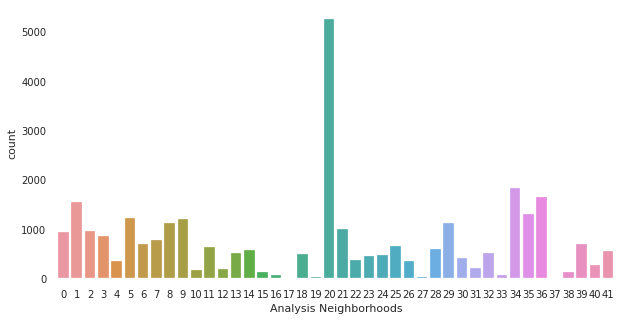

In [269]:
df['Analysis Neighborhoods'].value_counts(normalize=True,dropna=False)
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.countplot(x='Analysis Neighborhoods',data=wrangler.working)

fig.show()

In [270]:
##look at negativ deltas, 
df = wrangler.working 
neg_ttr = df.ttr.map(lambda td : td.total_seconds() < 0)
df[neg_ttr]['CaseID'].nunique() ,df[neg_ttr].shape       #one record per caseid here




(329, (329, 25))

In [271]:
wrangler.working.columns


Index(['CaseID', 'Opened', 'Closed', 'Updated', 'Status', 'Status Notes',
       'Responsible Agency', 'Category', 'Request Type', 'Request Details',
       'Address', 'Street', 'Neighborhood', 'Police District', 'Latitude',
       'Longitude', 'Source', 'Media URL', 'Current Police Districts',
       'Analysis Neighborhoods', 'Neighborhoods', 'ttr', 'case_year',
       'case_month', 'workload'],
      dtype='object')

In [272]:
wrangler.working['Request Type'].value_counts()

Bulky Items                                                5463
General Cleaning                                           4737
Encampment Reports                                         1952
Human or Animal Waste                                      1669
Graffiti on Building_commercial                             842
                                                           ... 
Construction Zone Tow-away Permits for Water Department       1
Graffiti on Fire_hydrant_puc                                  1
Building - Fire_Extinguishers_Missing_Expired                 1
Construction Zone Tow-away Permits for Ranger Pipeline        1
Construction Zone Tow-away Permits for DPW/Radio              1
Name: Request Type, Length: 281, dtype: int64

In [273]:
#pandas_profiling.ProfileReport(wrangler.working)
wrangler.working.Category.value_counts().index

Index(['Street and Sidewalk Cleaning', 'Graffiti', 'Abandoned Vehicle',
       'Encampments', 'Parking Enforcement', 'other', 'Damaged Property',
       'Litter Receptacles', 'Street Defects', 'Illegal Postings',
       'Homeless Concerns', 'Blocked Street or SideWalk', 'Noise Report',
       '311 External Request'],
      dtype='object')

In [274]:
wrangler.working.groupby(by=['case_year','case_month','Request Type'])[['CaseID','ttr']].agg({'CaseID': 'count'})
#produce stats by month and year
monthly_counts_by_request_type = wrangler.working.groupby(by=['case_year','case_month','Request Type']).agg({'CaseID': 'count', 'workload': np.mean, 'ttr': max})
monthly_counts_by_request_type.columns = ['case_count', 'avg_opencases', 'avg_ttr']
monthly_counts_by_request_type.sort_index(inplace=True)

monthly_counts = wrangler.working.groupby(by=['case_year','case_month']).agg({'CaseID': 'count', 'workload': np.mean, 'ttr': max})


In [275]:
monthly_counts

CaseID    workload                ttr
case_year case_month                                       
2008      7               91   17.010989  129 days 12:36:18
          8               93   23.989247  414 days 18:45:17
          9               87   24.827586 4269 days 00:36:47
          10              76   26.052632  299 days 20:04:03
          11              73   27.547945  235 days 00:55:26
...                      ...         ...                ...
2020      2              472  411.254237   97 days 20:26:39
          3              351  405.595442   64 days 04:24:48
          4              294  415.639456   56 days 14:08:53
          5              374  432.756684   32 days 22:09:44
          6               71  292.352113    2 days 18:48:00

[144 rows x 3 columns]

In [ ]:
monthly_counts_by_request_type.loc[(2009)]

monthly_counts.columns =['case_count', 'avg_opencases', 'avg_ttr']  # test regression on this  or remove
monthly_counts.plot(legend=False, figsize=(15,4))

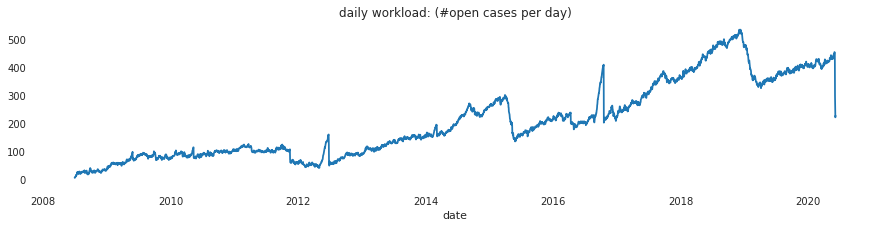

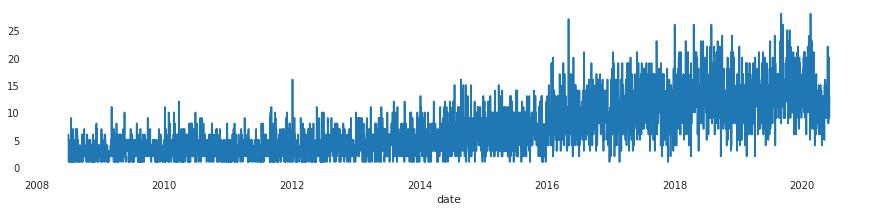

In [276]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.dates as mdates


daily = wrangler.working.copy()
daily['date'] = pd.DatetimeIndex(daily.Opened).date

daily_load=daily[['date','workload']].groupby('date').max()
daily_load.plot(legend=False, figsize=(15,3))
plt.title('daily workload: (#open cases per day)')
plt.show()

new_cases_daily = daily[['date','CaseID']].groupby('date').count() #daily new opens

new_cases_daily.plot(legend=False, figsize=(15,3))



### Linear trend within the times series :

Although the workload appears to be time serie attributes, we can see that there is a linear component as well:

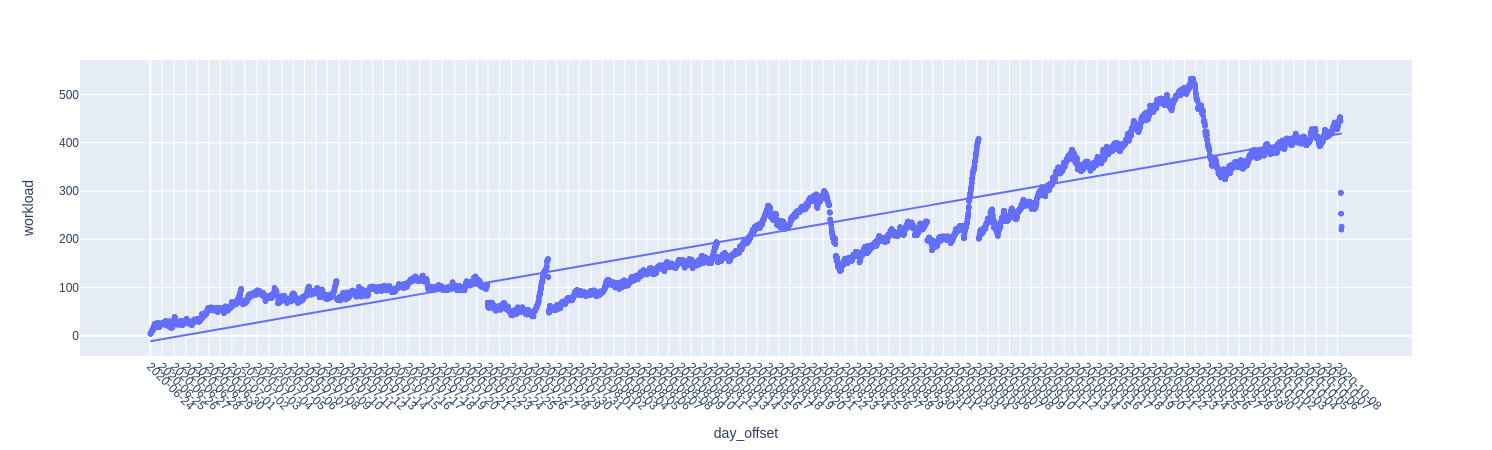

In [277]:
import plotly.express as px
from datetime import datetime

df_dl =daily_load.groupby('date').max()

df_dl['day_offset'] = (df_dl.index - df_dl.index[0]).days  #get an int represention of days since the first value


#need to create label list since we have to serialize the dates as ints for px to do the least squares
datelist = pd.date_range(datetime.today(), periods=df_dl.shape[0]).tolist()  #

fig = px.scatter(df_dl,x='day_offset', y='workload',trendline='ols')


fig.update_xaxes(tickangle=45,
                 tickmode = 'array',
                 tickvals = df_dl['day_offset'][0::40],
                 ticktext= [d.strftime('%Y-%m-%d') for d in datelist])

   
fig.show()

## Linear Regression in detail:

lets see what happens if we just treat the workload to a linear regression, with a random split:


In [278]:
#lets see what happens if we just treat the workload to a linear regression 

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

train, test = train_test_split(df_dl, test_size=.25)     

X_train = train.day_offset.values.reshape(-1,1)
y_train = train.workload.values.reshape(-1,1)
X_test = test.day_offset.values.reshape(-1,1)
y_test = test.workload.values.reshape(-1,1)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(model.coef_, model.intercept_)      #same slope calculated by px above
print(model.score(y_pred, y_test), mean_absolute_error(y_pred,y_test))  #clearly regression leaves something to be desired.

[[0.09824007]] [-11.4045169]
-2.1516388983501664 43.90552281279854


## Linear Model Coeffs and Error:

The sklearn linear model yields a slope that is the same as that calculated by plotly express above: **0.098** Note that the intercept is slightly shifted- but we are using a random sample here vs the enter dataframe above. We use both the model's *.score()* method and the *mean_absolute_error* package to estimate how well the linear model fits the data. The negative **R<sup>2</sup>** value of **-2.09** is telling us that our model does no better than a mean baseline. MAE is 42.26893511094306 


df_dl.workload.mean(), df_dl.workload.std()  = (207.0688439849624, 134.49243473471824)

### Will a tree model perform better?

Linear regression isnt really working well for this data. Shall we see if a tree model can better handle the non-monotonic change in workload? Using the same train / test split from above, we have to shape the arrays differently before feeding them to the tree ensemble. 

In [279]:
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual, IntRangeSlider
import ipywidgets as widgets


def f(md, xlims):
    model = RandomForestRegressor(max_depth=md)

    X_train = train.day_offset.values.reshape(-1, 1) 
    y_train = train.workload.values
    X_test = test.day_offset.values.reshape(-1, 1) 
    y_test = test.workload.values

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print('Mean Abs Err : ', mean_absolute_error(y_pred,y_test)) 
    
    fig,ax = plt.subplots()
    rfpred= pd.DataFrame(data=[y_test,y_pred]).T
    
    ax= rfpred[0].plot( figsize=(30,6), color='red')           # true values
    ax= rfpred[1].plot(                color='blue', alpha=.7) # predicted values
    ax.legend (['actual', 'predicted'])
    
    ax.set_xlim(xlims)
    plt.title('RF Model Predicted vs Actual \n Daily Workload: (Max Queue length)')
    plt.show()

xlimr= int(X_train[-1])

xlims =  IntRangeSlider(description='x window',
                        value=[0,xlimr],
                        min=   0,
                        max=   xlimr,
                        step = 50,
                        disabled=False,
                       readout=True)

md =  IntSlider(description='max_depth',
                min=1,
                max=10,
                step=1, 
                value=3)

interact(f, md=md,xlims=xlims)


interactive(children=(IntSlider(value=3, description='max_depth', max=10, min=1), IntRangeSlider(value=(0, 360…

<function __main__.f(md, xlims)>

## Got trees?  
   It is evident that the tree-based regressor has no problem fitting the wild variance of the daily queue length (workload) ##TODO##  change to queue length? Using the slider to redraw the plot with increasing depth and watch the MAE drop. But are we done? Can this model really predict future workload? Since we did **random** sampling of our data we would expect the fitted model to predict well on the test sets, if we have enough data points in each set. It
   
### Time-Based Split
   To test our Random Forest model further, we can create a time based split. The datetime index is sorted, we will re-train the model using the first 80% of the observations along the time axis, with the remaining 20% for test. Use the *training set%* slider to observe the effect on the prediction. If you think *that's bogus, use the dropdown*, and watch what happens when you change the split as follows: 
   out of the original train set, create a ***random*** 80% sample and use the remainder for validation. prepare to be amazed...
    

In [394]:
#use a time based split 
from ipywidgets import FloatSlider

def f(md,ts,tvt_split='OFF'):
    ## time axis split
    trainsize = int(df_dl.shape[0]*ts)  #initial split of 80/20 ffrom the slider default
    
    model = RandomForestRegressor(max_depth=md)
    
    train = df_dl.copy().iloc[0:trainsize]
    test =  df_dl.copy().iloc[trainsize:] 
    
    if tvt_split == 'ON' :                                           #random sample the first portion into train,val then we can test 
        train,val = train_test_split(train, test_size=.2)     
        X_val = val.day_offset.values.reshape(-1, 1) 
        y_val = val.workload.values
    
    X_train = train.day_offset.values.reshape(-1, 1) 
    y_train = train.workload.values
    X_test = test.day_offset.values.reshape(-1, 1) 
    y_test = test.workload.values
    
    model.fit(X_train, y_train)
    
    fig,ax = plt.subplots()
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    if tvt_split == 'ON':             
        y_val_pred = model.predict(X_val)
        plt.figtext(.145,.3,
                    f"val mae:{mean_absolute_error(y_val_pred,y_val):.2f}", 
                    ha='left',fontsize=15,color='green')   
     
        val['Val pred'] = y_val_pred     #add the predictions for val to df
        
        val.sort_index(inplace=True)
        val.plot( y= 'workload',  figsize=(30,6), color='red',ax=ax) #val actual
        val.plot( y='Val pred',  figsize=(30,6), color='green', ax=ax)#val predicted 
        ax.legend (['val actual', 'val predicted'])

    y_pred = model.predict(X_test)   
    
    plt.figtext(.5,.9,'RF model predicted values vs. actual,\n as function of split and max_depth',fontsize=20,ha='center')

    plt.figtext(.75,.3,f"test mae: {mean_absolute_error(y_pred,y_test):.2f}", fontsize=15, color='blue')
    
    test['Test predicted']= y_pred
    
    test.plot(y='workload', figsize=(30,6), color='maroon', ax=ax) #actual workload
    test.plot(y='Test predicted', figsize=(30,6), color='blue', ax=ax)#predicted on TEST

ts =  FloatSlider(description='training set%',min=.50, max=.9, step=.05 , value=.8)    
md =  IntSlider(description='max_depth',min=1,max=10, step=1,  value=3)

tvt_split = widgets.ToggleButtons(
    options=['ON', 'OFF'],
    value='OFF',
    description='Make Train-Val \n on time split',
    disabled=False,
    button_style='warning', # 'success', 'info', 'warning', 'danger' or ''
    orientation = 'vertical',
    tooltips=['On', 'Off'],
)
tvt_split = widgets.Dropdown(
    options=['OFF','ON'],
    value='OFF',
    description='3-way SPLIT',
    disabled=False,
    orientation='horizontal'
)
interact(f, md=md, ts=ts, tvt_split=tvt_split)



interactive(children=(IntSlider(value=3, description='max_depth', max=10, min=1), FloatSlider(value=0.8, descr…

<function __main__.f(md, ts, tvt_split='OFF')>

##  Wow this tree model is very smart!

This is what happens when you train your model on a time series with time based split! It appears to have determined that its not worth the effort and just guess a constant! but this 


### Where do we go from here? Lets do some window-looking. 

now that we can see the deficiencies of regression models, we need to introduce some means to better interpret the data. If there appears to be a periodic fluctuation, we can use a **rolling average**, or **moving mean** to smooth out short term variance and visualize larger trends. Below I introduce another calculated feature of the data, the *time to resolution* or *ttr* for a specific case. This is very simple; it is the time difference between the open and close for that case. In the data its expressed as a *timedelta* object, and cast to various datatypes, such as *



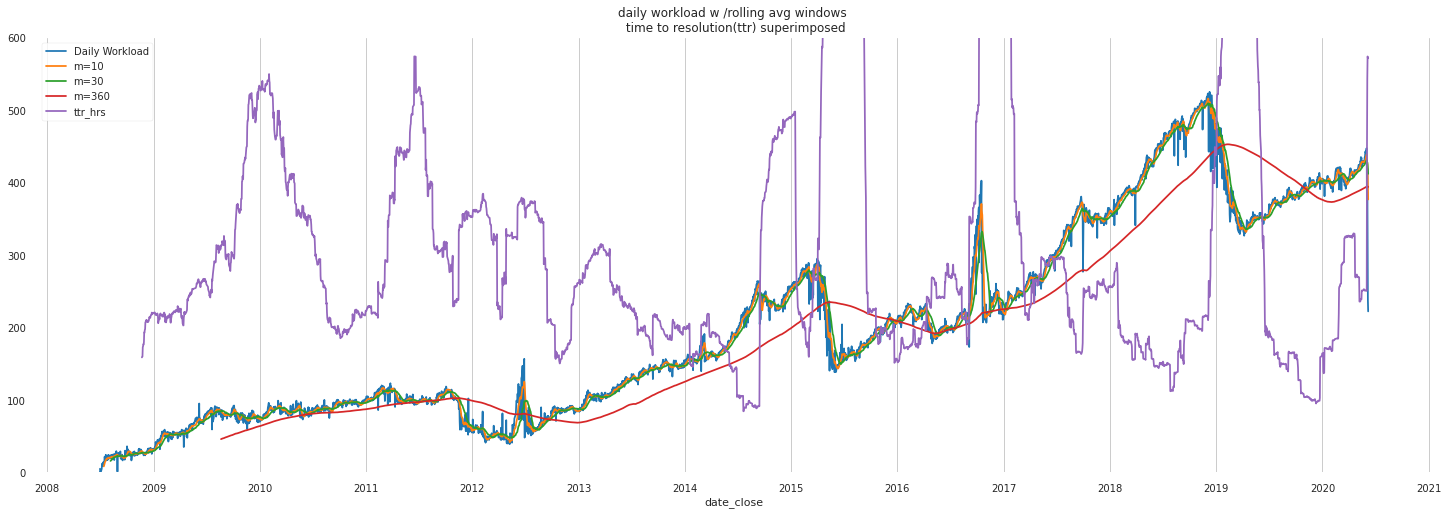

In [282]:
closed_ttr_day = wrangler.working.copy()


closed_ttr_day['ttr_sec'] = closed_ttr_day['ttr']  #keep seconds
closed_ttr_day['ttr'] = closed_ttr_day['ttr'].dt.total_seconds()/3600   #convert to hours

closed_ttr_day['date_close'] = pd.DatetimeIndex(closed_ttr_day.Closed).date

closed_ttr_day = closed_ttr_day.groupby('date_close')[['CaseID','workload','ttr']].agg({'CaseID': 'count', 'workload': np.mean, 'ttr': 'mean'})
closed_ttr_day = closed_ttr_day.groupby('date_close')[['CaseID','workload','ttr']].agg({'CaseID': 'count', 'workload': 'max', 'ttr': 'mean'})

closed_ttr_day.columns=['case_count','daily_workload', 'avg_ttr_hours']


years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')


ax= closed_ttr_day.daily_workload.plot(figsize=(25,8))

closed_ttr_day.daily_workload.rolling(window=10).mean().plot(ax=ax)
closed_ttr_day.daily_workload.rolling(window=30).mean().plot(ax=ax)
closed_ttr_day.daily_workload.rolling(window=360).mean().plot(ax=ax)

closed_ttr_day.avg_ttr_hours.rolling(window=120).mean().plot(ax=ax)      #


ax.set_title('daily workload w /rolling avg windows \n time to resolution(ttr) superimposed')

ax.xaxis.grid(True, which='major')

ax.set_ylim(0,600)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_major_formatter(years_fmt)


ax.legend(['Daily Workload', 'm=10', 'm=30', 'm=360', 'ttr_hrs'])
plt.show()

In [402]:
closed_ttr_day

,case_count,daily_workload,avg_ttr_hours
date_close,,,
2008-07-01,1,5.000000,6.716389
2008-07-02,1,0.000000,21.144167
2008-07-05,1,2.000000,89.510000
2008-07-07,1,5.000000,91.886667
2008-07-08,1,12.000000,2.459167
...,...,...,...
2020-06-02,1,323.237805,24416.341335
2020-06-03,1,419.301887,10817.836038
2020-06-04,1,342.220000,5662.015733


## Rolling Means for Daily Workload

To see through some of the daily variance, and try to look for seasonal effects we can calculate the rolling means with various window sizes. after doing so we can see that there is a slight upward linear trend in the daily workload but with the extreme smoothing using a 360 day window, the red line, there also appears to be a multi-year cycle, perhaps releated to staffing and or process changes, that reduce the workload for a time before the upward trend continues. 

In contrast, the *mean time to resolution (ttr) in hours* shows extreme fluctuations, but in perhaps without a clear upward trend. We'll look at this more later

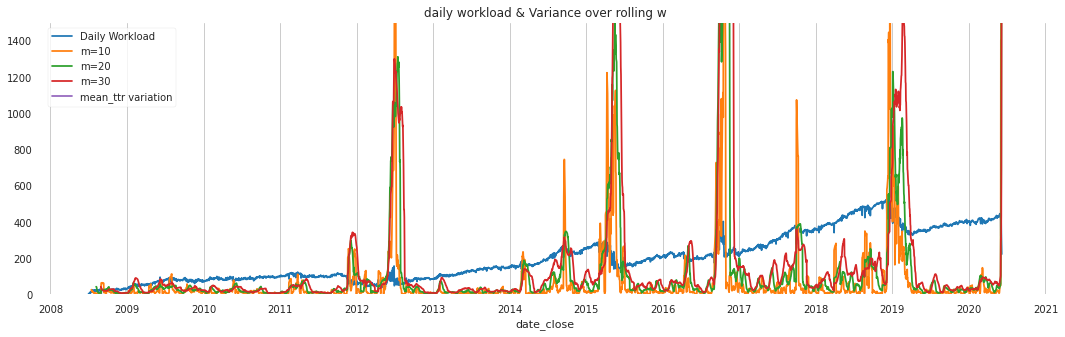

In [283]:


ax= closed_ttr_day.daily_workload.plot(figsize=(18,5))
ax.set_title('daily workload & Variance over rolling w')

closed_ttr_day.daily_workload.rolling(window=10).var().plot(ax=ax)
closed_ttr_day.daily_workload.rolling(window=30).var().plot(ax=ax)
closed_ttr_day.daily_workload.rolling(window=50).var().plot(ax=ax)
closed_ttr_day.avg_ttr_hours.rolling(window=50).var().plot(ax=ax)

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')


ax.legend(['Daily Workload', 'm=10', 'm=20', 'm=30','mean_ttr variation'])
ax.xaxis.grid(True, which='major')

ax.set_ylim(0,1500)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_major_formatter(years_fmt)

plt.show()

date_close
2008-07-01        6.716389
2008-07-02       21.144167
2008-07-05       89.510000
2008-07-07       91.886667
2008-07-08        2.459167
                  ...     
2020-06-02    24416.341335
2020-06-03    10817.836038
2020-06-04     5662.015733
2020-06-05       14.266972
2020-06-06        3.414722
Name: avg_ttr_hours, Length: 4128, dtype: float64

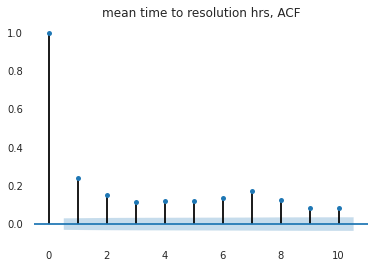

In [401]:
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf

x = closed_ttr_day.avg_ttr_hours
plot_acf(np.array(x),lags=10, title='mean time to resolution hrs, ACF')

#plot_acf(np.array(closed_ttr_day.case_count),lags=20, title='case counts')  #check case count (open/close count) autocorrelation


In [285]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(daily_load.iloc[:,0].values)
print(f'p value is {result[1]}')


p value is 0.4110634655953654


Since the p value is small than the significance level of 0.05, we can reject the null hypothesis that the time series data is non-stationary. Thus, the time series data is stationary.

In [286]:
result =closed_ttr_day.iloc[:,2].values    #column is mean time to resolution in hours

print(f'p value is {result[1]}')  # this series is NOT stationary

p value is 21.144166666666667


In [287]:
mean_ttr_by_cat = wrangler.working.groupby(['Category','Request Type']).ttr.apply(lambda x : np.mean(x))
#mean_ttr_by_cat.sort_values(ascending=False).head(5).index.tolist()
mean_ttr_by_cat.head(90)



Category                    Request Type                                      
311 External Request        Damaged_Property                                      22 days 05:49:23.230769
                            Garbage                                              152 days 17:17:50.750000
                            Graffiti                                              59 days 17:47:51.275590
                            Human/Animal Waste                                            0 days 09:56:30
                            Illegal_Posting                                        6 days 16:38:17.500000
                            Other                                                  3 days 03:11:18.111111
                            Sewer_Water_Storm_Conditions                                  0 days 01:07:34
                            Sidewalk_or_Curb_Issues                               82 days 23:08:25.888888
                            Utility Lines/Wires                          

In [404]:

def f(stepin):
    fig, ax = plt.subplots()
    needle = '(needle)|(syringe)|(sharp)'

    sharps = wrangler.working['Request Details'].str.contains(needle, case=False)
    med_waste = wrangler.working['Request Type'] == 'Medical Waste'
     
    poop2 = wrangler.working['Request Details'].str.contains('Human', case=False)
    camp  = wrangler.working['Request Details'].str.contains('Encampment', case=False)
    wrangler.working[sharps]
    wrangler.working[med_waste]

    zlt = wrangler.working.Latitude == 0
    zln = wrangler.working.Longitude == 0
    zl =  (zln | zlt)

  

    sdic = {'poop': (poop2 & ~zl), 'needles': med_waste, 'people': camp}  #selector label: boolfilter

    #ax1 = wrangler.working[poop2 & ~zl].plot(x='Longitude',y='Latitude', color='red', kind ='scatter',figsize=(10,10), title = 'SF poopmap', alpha=.5)
    #ax2 = wrangler.working[med_waste & ~zl].plot(x='Longitude',y='Latitude', color='orange', kind ='scatter',figsize=(10,10), title = 'SF needles', alpha=.5)


    ax = wrangler.working[sdic[stepin]].plot(x='Longitude',y='Latitude', color='orange', kind ='scatter',figsize=(10,10), title = 'Watch your Step.. ', alpha=.5)
    fig.show()
    
soptions= ['poop','needles','people']
stepin = widgets.SelectionSlider(
    options=soptions,
    value='poop',
    description='I like to step on...',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)


In [ ]:
## view some neighborhood stats
#wrangler.working.groupby(by=['case_year','Neighborhood','Request Type'])[['CaseID','ttr']].agg({'CaseID': 'count','ttr': lambda x: x.mean()})
ttr_by_neighborhood  = wrangler.working.groupby(by=['Neighborhood','Request Details'])[['CaseID','ttr']].agg({'CaseID': 'count','ttr': lambda x: x.mean()})
poop2 = ttr_by_neighborhood.index.get_level_values('Request Details').str.contains('Human', case=False)
med_waste = ttr_by_neighborhood.index.get_level_values('Request Details') == 'Medical Waste'

ttr_by_neighborhood[poop2]
ttr_by_neighborhood[med_waste]


## Explore class Distribution for ttr:


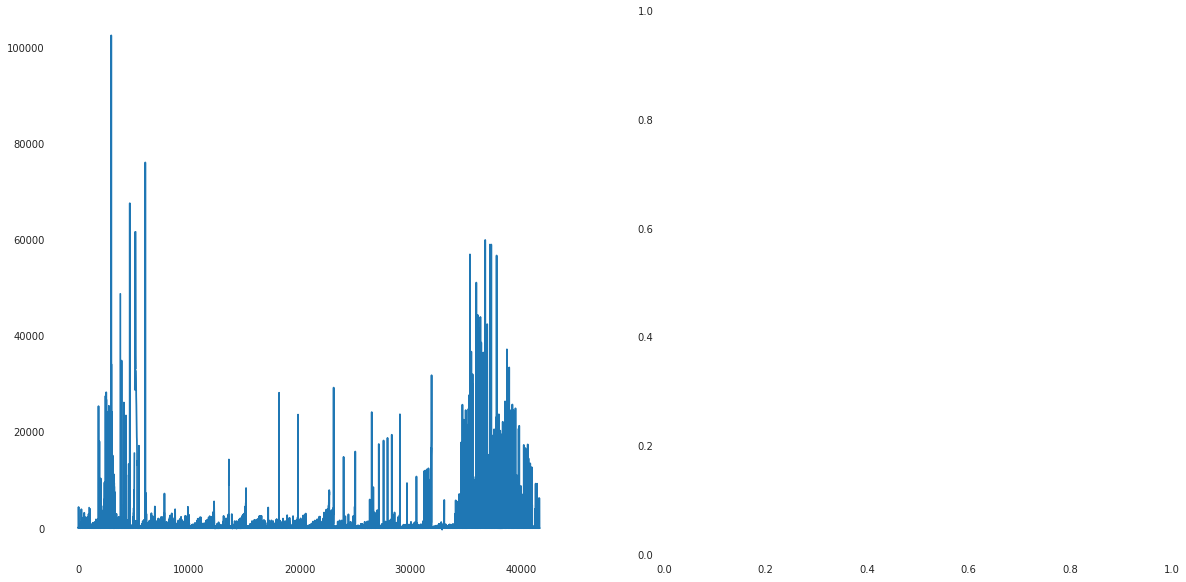

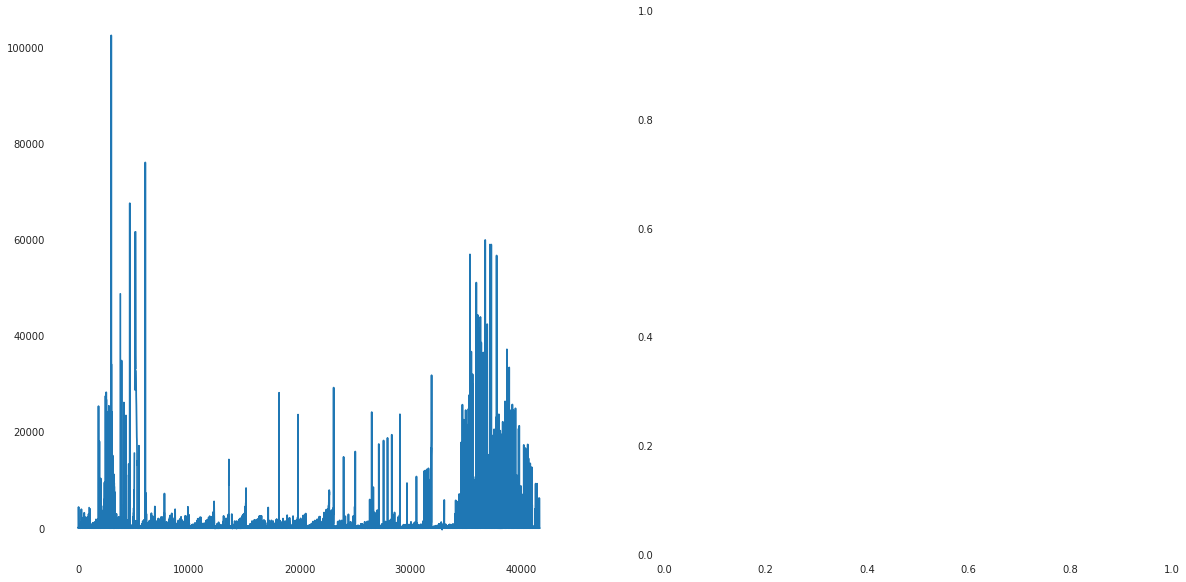

Output()

In [577]:
#explore ttr class distribution


(wrangler.working.ttr.dt.total_seconds()/3600).describe()
fig, (ax1,ax2) = plt.subplots(1,2,figsize =(20,10))
(wrangler.working.ttr.dt.total_seconds()/3600).plot(ax=ax1)


min_value =0
max_value =100
l_m_bound = 8
m_h_bound = 80
xb = 20000      #low pass filter  

ttr = wrangler.working.ttr.dt.total_seconds()/3600  #ttr in   hours

a = widgets.FloatRangeSlider(min=ttr.min(),
                             max=1000,
                             value=[l_m_bound,m_h_bound],
                             description='define the class boundaries',
                             readout_format='.1f',
                             readout=False
                            )
b = widgets.FloatLogSlider(         #adjust extreme value cutoff
    value=xb,
    base=10,
    min=-10, # max exponent of base
    max=10, # min exponent of base
    step=0.2, # exponent step
    description='extreme cutoff'
)
    

ui = widgets.HBox([a,b])

def f(a,b):
    print(a)
    lb,ub = a   #bounds for middle class
     xb=b
    def mapttrs(ttr):
        low  = ttr < lb   
        med  = lb <= ttr <= ub
        high = ub < ttr < xb
        ext  = ttr >= xb
        if low:
            return 'low'
        elif med:
            return 'med'
        elif high:
            return 'high'
        else:
            return 'xb'
    
    print(ttr.map(mapttrs).value_counts(normalize=True))
    print(f"\nHigh cutoff= {b}")
    print(f"bounds for med class: {a}")
    
    valct = (ttr.map(mapttrs).value_counts(normalize=True))
    xbval = (f"\nExtreme Values cutoff= {b}")
    medval= (f"bounds for med class: {a}")
    ax2.text(.5,.5,f"{valct}\n{xbval}\n{medval}") 
    fig.show()
out = widgets.interactive_output(f, {'a': a, 'b': b})
display(ui, out)


In [505]:
def mapttrs(ttr):
    low  = ttr < 8   
    med  = 8 <= ttr <= 80
    high = 80 < ttr < 20000
    ext  = ttr >= 20000
    if low:
        return 'low'
    elif med:
        return 'med'
    elif high:
        return 'high'
    else:
        return 'xb'
df= wrangler.working.copy()
df['ttr_class'] = (df['ttr'].dt.total_seconds()/3600).map(mapttrs)
df['opened_hour'] = df.Opened.dt.hour
df['opened_dow'] = df.Opened.dt.dayofweek


In [523]:

features = df.columns.drop(['CaseID','Opened','Closed','Updated','Status','Status Notes','ttr','workload','ttr_class']) #drop time or status related columns
df[features].dtypes

Responsible Agency           object
Category                     object
Request Type                 object
Request Details              object
Address                      object
Street                       object
Neighborhood                 object
Police District              object
Latitude                    float64
Longitude                   float64
Source                       object
Media URL                    object
Current Police Districts    float64
Analysis Neighborhoods        int64
Neighborhoods                 int64
case_year                     int64
case_month                    int64
opened_hour                   int64
opened_dow                    int64
dtype: object

In [540]:
from sklearn.linear_model import LogisticRegression
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, recall_score

target='ttr_class'

train,test = train_test_split(df, train_size=.8, random_state=99)
train,val  = train_test_split(train, train_size=.8, random_state=99)

print(train.shape, val.shape)

X_train = train[features]
y_train = train[target]
X_val   = val[features]
y_val   = val[target]

X_test = test[features]
y_test = test[target]

logreg = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression(max_iter=100)
)
logreg.fit(X_train,y_train);
y_val_pred= logreg.predict(X_val)
y_pred_proba=logreg.predict_proba(X_val); #need for ROC
y_test_pred= logreg.predict(X_test)
accuracy_score(y_val,y_val_pred) ,accuracy_score(y_test,y_test_pred) 


(19432, 28) (4859, 28)


(0.48075735748096315, 0.46039848509797465)

In [547]:
import category_encoders as ce
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
import eli5
from eli5.sklearn  import PermutationImportance

baseline= df[target].value_counts(normalize=True).values[0] #baseline
k=6
models = [XGBClassifier() , RandomForestClassifier(),DecisionTreeClassifier() ]
    
for model in models:
    pipe = pipe = make_pipeline(ce.OrdinalEncoder(),SimpleImputer(),StandardScaler(),SelectKBest(k=k),model)
    pipe.fit(X_train,y_train)
    print(list(pipe.named_steps.keys())[-1])
    print('Training Accuracy:', pipe.score(X_train, y_train))
    print('Validation Accuracy:', pipe.score(X_val, y_val))
    print('Test Accuracy:', pipe.score(X_test, y_test))
    print('baseline Accuracy:', baseline,'\n')
    print(classification_report(y_test, pipe.predict(X_test)))


xgbclassifier
Training Accuracy: 0.7445965417867435
Validation Accuracy: 0.668656102078617
Test Accuracy: 0.6678741972665898
baseline Accuracy: 0.3372085364247135 

              precision    recall  f1-score   support

        high       0.67      0.62      0.64      1914
         low       0.78      0.77      0.78      2034
         med       0.57      0.62      0.59      2042
          xb       0.59      0.35      0.44        83

    accuracy                           0.67      6073
   macro avg       0.65      0.59      0.61      6073
weighted avg       0.67      0.67      0.67      6073

randomforestclassifier
Training Accuracy: 0.8557533964594484
Validation Accuracy: 0.6332578719901214
Test Accuracy: 0.6441626873044624
baseline Accuracy: 0.3372085364247135 

              precision    recall  f1-score   support

        high       0.62      0.63      0.62      1914
         low       0.75      0.77      0.76      2034
         med       0.56      0.55      0.56      2042
        

In [550]:

#perm = PermutationImportance(model, random_state=887).fit(X_val_enc,y_val)
#eli5.show_weights(perm, feature_names = X_val_enc.columns.tolist())

pipe.named_steps['ordinalencoder'].get_feature_names()


['Responsible Agency',
 'Category',
 'Request Type',
 'Request Details',
 'Address',
 'Street',
 'Neighborhood',
 'Police District',
 'Latitude',
 'Longitude',
 'Source',
 'Media URL',
 'Current Police Districts',
 'Analysis Neighborhoods',
 'Neighborhoods',
 'case_year',
 'case_month',
 'opened_hour',
 'opened_dow']

decisiontreeclassifier
[[ 867  170  441   21]
 [ 148 1218  276    6]
 [ 491  335  810    9]
 [  27   10   10   20]]


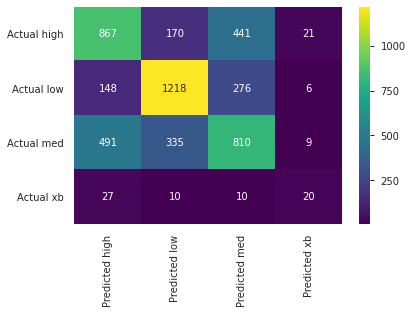

In [553]:
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix


y_val_pred = pipe.predict(X_val)

confusion = confusion_matrix(y_val, y_val_pred,  labels=None, sample_weight=None, normalize=None)
print(list(pipe.named_steps.keys())[-1])
print(confusion)

unique_labels(y_test)

def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

plot_confusion_matrix(y_val, y_val_pred);


